In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.layers import Activation, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

## Load and preprocess training and testing dataset

In [6]:
# Import training and testing dataset and save to the dataset_buffer
df = pd.read_excel("D:\willy\OneDrive - 長庚大學\Git\ARC2023\data\_all0to6km.xlsx")

speed = df.iloc[1:, 0].values
p_sc = df.iloc[1:, 1].values
dist = df.iloc[1:, 2].values
thro = df.iloc[1:, 3].values
length = len(thro)


In [ ]:
X = np.vstack((speed, p_sc, dist))

y = thro
X = np.transpose(X)

# print(X.shape)
X = X.reshape(length, 1, 3)
X = np.expand_dims(X, axis=2)
X = X.reshape(length, 1, 3,1)
print(X.shape)
y = np.transpose(y)


print(y.shape)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

## Load and process training and testing dataset

In [10]:
# Import training and testing from dataset_buffer
train_images = X_train
train_labels = y_train

test_images = X_val
test_labels = y_val

## Model define and create

In [6]:
filter_x = 1
filter_y = 1

model = Sequential()
ip_shape = (1, 3, 1)
# Conv1
model.add(Conv2D(filters=1, 
                 kernel_size=(1, 1), 
                 padding="same",  
                 input_shape=ip_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(padding="same"))

In [7]:

#FC1
model.add(Flatten())
model.add(Dense(5))

model.add(BatchNormalization())
model.add(Activation("relu"))

#FC2
model.add(Dense(1))

In [8]:
# Show your model

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 1, 3, 1)           2         
                                                                 
 batch_normalization_2 (Batc  (None, 1, 3, 1)          4         
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 1, 3, 1)           0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 2, 1)          0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 5)                

## Model training

In [14]:
# Training model

#Define optimizer loss function and merics 
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              )

# Set training
hisory = model.fit(train_images, train_labels,
          verbose = 1,
          epochs = 400
          )

Epoch 1/400
7/7 [==============================] - 1s 70ms/step - loss: 817.0556
Epoch 2/400
7/7 [==============================] - 0s 71ms/step - loss: 815.2504
Epoch 3/400
7/7 [==============================] - 1s 80ms/step - loss: 813.4243
Epoch 4/400
7/7 [==============================] - 0s 61ms/step - loss: 812.3450
Epoch 5/400
7/7 [==============================] - 0s 58ms/step - loss: 810.2856
Epoch 6/400
7/7 [==============================] - 0s 72ms/step - loss: 808.8390
Epoch 7/400
7/7 [==============================] - 0s 72ms/step - loss: 807.0458
Epoch 8/400
7/7 [==============================] - 0s 55ms/step - loss: 805.8114
Epoch 9/400
7/7 [==============================] - 0s 70ms/step - loss: 803.2888
Epoch 10/400
7/7 [==============================] - 0s 59ms/step - loss: 802.3747
Epoch 11/400
7/7 [==============================] - 1s 77ms/step - loss: 799.8197
Epoch 12/400
7/7 [==============================] - 1s 73ms/step - loss: 797.4215
Epoch 13/400
7/7 [=======

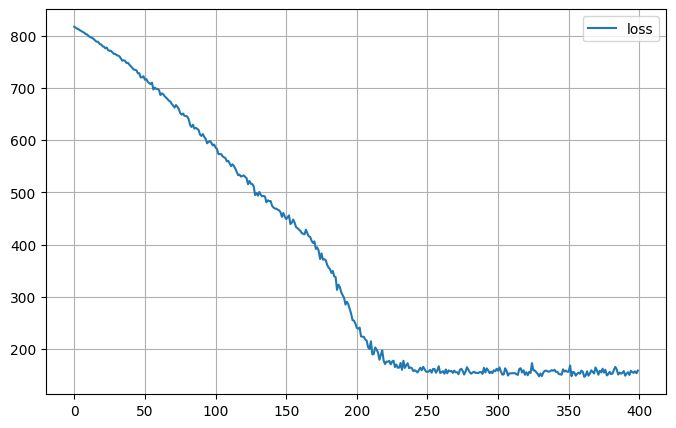

In [15]:
import matplotlib.pyplot as plt
pd.DataFrame(hisory.history).plot(figsize=(8, 5))
plt.grid(True)

plt.show()

In [16]:
pred = model.predict(X)

10/10 [==============================] - 0s 2ms/step


#Save weights of this model  
model.save_weights('my_model.h5')

#load weights to this TensorFlow model  
model.load_weights('my_model.h5')

In [18]:
# Save model and weights of this model
model.save('conv_dense5_new')

INFO:tensorflow:Assets written to: conv_dense5_new\assets


INFO:tensorflow:Assets written to: conv_dense5_new\assets


In [19]:
# lOAD model and weights of this model
model_2 = keras.models.load_model('conv_dense5_new')

In [20]:
model = model_2

## Reload and Evaluate Different Model

In [ ]:
predict = model.predict(X)

In [ ]:
def mse(data1,data2,l):
    sum = 0
    for i in range(l):
        temp = 0
        temp = data1[i] - data2[i]
        sum = temp * temp + sum
    
    return sum/l


mean_square_error = mse(predict,y,length)
print(mean_square_error)

---------------------------------------------------------------------------------------------------------------------

## Convert model into TFLM format

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

In [22]:
test_images = tf.cast(test_images, tf.float32)
tf_lite_ds = tf.data.Dataset.from_tensor_slices((test_images)).batch(1) #construct a dataset 

def representative_data_gen():
    for input_value in tf_lite_ds.take(100):
        yield [input_value]
    
converter.representative_dataset = representative_data_gen

In [ ]:
import pathlib

converted_model = converter.convert()

generated_dir = pathlib.Path("generated/")
generated_dir.mkdir(exist_ok=True, parents=True)
converted_model_file = generated_dir/"conv_dense5_new.tflite"
converted_model_file.write_bytes(converted_model)

In order to integrate converted model into TFLM application we have to save it as a C array. One way to do that is to use **xxd** utility available on Linux or in Cygwin/MinGW terminals on Windows. Open terminal and run following commands:

```
cd generated/
xxd -i emnist_model_int8.tflite > model.h
```

The model is ready to be integrated into TFLM application.

## Evaluate TensorFlow Lite INT-8 Model

Full test set contains 14800 samples. Evaluating int8 model on it might take more than 10 minutes. 
If you want to get estimation faster, please, limit number of samples to be evaluated by reducing **max_samples** value

In [ ]:
max_samples = int(test_images_database.shape[0] * 0.20)

print(max_samples)

In [376]:
import pathlib

generated_dir = pathlib.Path("generated/")
generated_dir.mkdir(exist_ok=True, parents=True)
converted_model_file = generated_dir/"conv_dense5_new.tflite"

interpreter = tf.lite.Interpreter(model_path=str(converted_model_file))
interpreter.allocate_tensors()

# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    scale, zero_point = interpreter.get_output_details()[0]['quantization']

    prediction_values = []
    
    for tflm_test_image in tflm_test_images[:max_samples]:
        # Pre-processing: add batch dimension, quantize and convert inputs to int8 to match with
        # the model's input data format.
        tflm_test_image = np.expand_dims(tflm_test_image, axis=0) #.astype(np.float32)
        tflm_test_image = np.int8(tflm_test_image / scale + zero_point)
        interpreter.set_tensor(input_index, tflm_test_image)

        interpreter.invoke()

        # Find the letter with highest probability
        output = interpreter.tensor(output_index)
        result = np.argmax(output()[0])
        prediction_values.append(result)
    
    accurate_count = 0
    for index in range(len(prediction_values)):
        if prediction_values[index] == ans_test_labels[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_values)

    return accuracy * 100

In [ ]:
# Import training and testing from dataset_buffer
tflm_test_images = test_images_database
ans_test_labels = test_labels_database

def thinning(image):
    return np.where(image < 210.0, 0, 255)

tflm_test_images = thinning(tflm_test_images)
tflm_test_images = (tflm_test_images - 128.0) / 128.0

Please, keep in mind that full test dataset evaluation on int8 model may take several minutes. 

In [ ]:
print(str(evaluate_model(interpreter)) + "%")

Evaluate the accuracy without normalizing data

In [ ]:
# Import training and testing from dataset_buffer
tflm_test_images = test_images_database
ans_test_labels = test_labels_database

tflm_test_images = (tflm_test_images - 128.0) / 128.0

In [ ]:
print(str(evaluate_model(interpreter)) + "%")

-----